### Dataset

https://www.kaggle.com/datasets/aayush9753/image-colorization-dataset

### Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio

### Load and preprocess the data

In [62]:
data_dir = 'data'  
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_color_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train_color'),
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    classes=['.'],  # Treat all files as belonging to the same class
    shuffle=False 
)

train_gray_gen = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train_black'),
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    classes=['.'],  # Treat all files as belonging to the same class
    shuffle=False
)

train_gen = zip(train_gray_gen, train_color_gen)

Found 14 images belonging to 1 classes.
Found 14 images belonging to 1 classes.


In [70]:
test_color_gen = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test_color'),
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='rgb',
    classes=['.'],
    shuffle=False
)

test_gray_gen = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'test_black'),
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    color_mode='grayscale',
    classes=['.'],
    shuffle=False
)

test_gen = zip(test_gray_gen, test_color_gen)

Found 3 images belonging to 1 classes.
Found 3 images belonging to 1 classes.


### Prepare data for the model

In [71]:
def get_ab_channels(generator):
    for gray_batch, color_batch in generator:
        lab_batch = rgb2lab(color_batch)
        yield gray_batch, lab_batch[:,:,:,1:] / 128  # Normalize AB channels
train_data = get_ab_channels(train_gen)

In [72]:
X_test, y_test = [], []
for gray_batch, color_batch in test_gen:
    X_test.extend(gray_batch)
    lab_batch = rgb2lab(color_batch)
    y_test.extend(lab_batch[:, :, :, 1:] / 128)
X_test = np.array(X_test)
y_test = np.array(y_test)

### Model Architecture (Autoencoder)

#### Autoencoders for Image Colorization

#### What is an Autoencoder?
An autoencoder is a type of artificial neural network used for unsupervised learning tasks such as dimensionality reduction, feature extraction, and anomaly detection. It comprises two key components:

- Encoder: This part compresses the input data into a lower-dimensional representation called the latent space or bottleneck. The encoder learns to capture the most salient features of the data in this compressed representation.

- Decoder: This part reconstructs the original input from the latent space representation. The decoder learns to generate data that closely resembles the input, thereby learning the underlying structure of the data.
The training process involves minimizing a loss function, often the Mean Squared Error (MSE) or other reconstruction losses, to ensure the reconstructed output is as close to the original input as possible.

#### How Autoencoders Work
The encoder maps the input data to the latent space using a series of transformations (e.g., convolutional layers for images). The decoder then reverses this process, attempting to generate the original data from the latent space representation. By training the autoencoder to minimize the reconstruction error, it learns to capture the essential features of the data in the latent space, discarding noise and redundant information.

#### Autoencoders for Image Colorization
In the context of image colorization, autoencoders are used to predict the missing color information in a grayscale image.

1. Input: The input to the autoencoder is a grayscale image (representing the L channel in the Lab color space).
2. Encoder: The encoder compresses the grayscale image into a latent space representation that captures its structural information.
3. Decoder: The decoder takes the latent representation and predicts the missing color information (ab channels in the Lab color space).
4. Output: The output is a colorized image.

References
- GeeksforGeeks: Colorization Autoencoders using Keras: https://www.geeksforgeeks.org/colorization-autoencoders-using-keras/   
- Kaggle: Automatic Image Colorization Using Machine Learning: https://xiangyutang2.github.io/auto-colorization-autoencoders/
- ResearchGate: Image Colorization Using Autoencoders: https://www.researchgate.net/publication/354964311_Image_Colorization_Using_Autoencoders

In [ ]:
input_img = Input(shape=(256, 256, 1))  # Grayscale input
# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
x = BatchNormalization()(x)
encoded = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
output_img = Conv2D(2, (3, 3), activation='tanh', padding='same')(x) 

model = Model(input_img, output_img)

# Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=[psnr])
model.fit(train_data, epochs=50, steps_per_epoch=len(train_color_gen), validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

### Evaluate

model.evaluate(X_test, y_test)

In [ ]:
def display_results(bw_images, color_images, predictions, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Display original black and white image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(bw_images[i].reshape(256, 256), cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Display colorized image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(lab2rgb(np.dstack((bw_images[i].reshape(256, 256, 1), predictions[i] * 128))))
        plt.title("Colorized")
        plt.axis("off")

        # Display ground truth color image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(lab2rgb(color_images[i]))
        plt.title("Ground Truth")
        plt.axis("off")

# Get predictions on test set
display_results(X_test, y_test, predictions)

### Model Architecture (VGG 16 + Decoder with Skip Connections)

#### VGG16 for Image Colorization
VGG16 is a convolutional neural network architecture that has been pre-trained on a large dataset (ImageNet) for image classification. It has learned to extract a wide range of features from images, making it a valuable resource for transfer learning in image-related tasks.

In the context of image colorization, VGG16 serves as the encoder part of our model. The pre-trained layers of VGG16 are frozen (i.e., their weights are not updated during training) to preserve the learned features. These features are then passed to a custom decoder network, which is trained to predict the missing color information (ab channels) from the features extracted by VGG16.

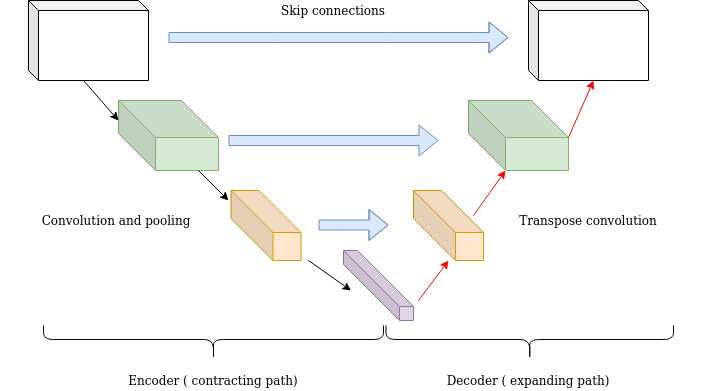

Intuitive Explanation of Skip Connections in Deep Learning : https://theaisummer.com/skip-connections/

In [ ]:
input_img = Input(shape=(256, 256, 1))

# VGG16 as Encoder (Transfer Learning)
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
vgg.trainable = False  # Freeze VGG layers initially
vgg_features = vgg(tf.image.grayscale_to_rgb(input_img))

# Decoder with Skip Connections
skip_layers = [
    'block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3'
]
decoder_input = encoded = vgg_features

for layer_name in reversed(skip_layers):
    skip_connection = vgg.get_layer(layer_name).output
    x = Conv2D(skip_connection.shape[-1], (3, 3), activation='relu', padding='same')(decoder_input)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Concatenate()([x, skip_connection])
    decoder_input = x

# Final Decoder Layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_input)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
output_img = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)

model = Model(input_img, output_img)

In [ ]:
#Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=[psnr])
model.fit(train_data, epochs=50, steps_per_epoch=len(train_color_gen), validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluate
model.evaluate(X_test, y_test)

# Visualize Predictions (same as before)
predictions = model.predict(X_test)

def display_results(bw_images, color_images, predictions, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Display original black and white image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(bw_images[i].reshape(256, 256), cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Display colorized image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(lab2rgb(np.dstack((bw_images[i].reshape(256, 256, 1), predictions[i] * 128))))
        plt.title("Colorized")
        plt.axis("off")

        # Display ground truth color image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(lab2rgb(color_images[i]))
        plt.title("Ground Truth")
        plt.axis("off")

# Get predictions on test set
display_results(X_test, y_test, predictions)

### Model Architecture (ResNet50 Encoder + Decoder with Skip Connections)

#### Pure Autoencoder:

- Learns Representations from Scratch: The encoder part of a pure autoencoder is trained to learn compressed representations (latent space) solely from the input data itself.

- Symmetrical Architecture: Typically, autoencoders have a symmetrical structure, where the decoder mirrors the encoder to reconstruct the original input as closely as possible.

   
#### Our Model with Transfer Learning:

- Leveraging Existing Knowledge: By using ResNet50, we're starting with an encoder that's already been trained on a massive dataset (ImageNet). It has learned to extract meaningful features from images, which are likely relevant to colorization as well.
   
- Asymmetrical Architecture: The ResNet50 encoder is much deeper and more complex than a typical autoencoder encoder. The decoder we've added is also likely simpler than the ResNet50 encoder.

- Focus on Prediction, Not Reconstruction: The primary goal of this model is not to reconstruct the original input image perfectly (as in a pure autoencoder), but to predict the missing color information (ab channels) based on the features extracted by ResNet.

#### So, What Are We Using?

- Hybrid Approach: The model can be described as a hybrid that combines transfer learning (using ResNet50) with a custom decoder architecture.

- Encoder-Decoder Structure: It still retains the encoder-decoder structure, but the encoder isn't solely trained on the colorization task.

- Goal: The goal is still to predict color, but the pre-trained ResNet50 encoder gives us a powerful starting point for feature extraction.

#### Benefits of this Hybrid Approach:

- Leveraging Rich Features: ResNet50 has learned to detect complex features in images, potentially helping the model understand image structure better and produce more realistic colorizations.   

- Faster Training: Starting with a pre-trained encoder can significantly reduce training time compared to training a purely custom autoencoder from scratch.

- Improved Performance (Potentially): By using the knowledge from a powerful pre-trained model, you might achieve better colorization results than with a simpler autoencoder.

In [ ]:

input_img = Input(shape=(256, 256, 1))

# ResNet50 as Encoder (Transfer Learning)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet.trainable = False  # Freeze ResNet layers initially
resnet_features = resnet(tf.image.grayscale_to_rgb(input_img))

# Decoder with Skip Connections
skip_layers = [
    'conv1_relu', 'conv2_block3_out', 'conv3_block4_out', 'conv4_block6_out'
]
decoder_input = resnet_features
for layer_name in reversed(skip_layers):
    skip_connection = resnet.get_layer(layer_name).output
    x = Conv2D(skip_connection.shape[-1], (3, 3), activation='relu', padding='same')(decoder_input)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Concatenate()([x, skip_connection]) 
    decoder_input = x

# Final Decoder Layers
x = Conv2D(64, (3, 3), activation='relu', padding='same')(decoder_input)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
output_img = Conv2D(2, (3, 3), activation='tanh', padding='same')(x) 

model = Model(input_img, output_img)

# Compile and Train
model.compile(optimizer='adam', loss='mse', metrics=[psnr])
model.fit(train_data, epochs=50, steps_per_epoch=len(train_color_gen), validation_data=(X_test, y_test),
          callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

# Evaluate the Model
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("Test loss, Test PSNR:", results)

# Visualize Predictions
predictions = model.predict(X_test)

def display_results(bw_images, color_images, predictions, n=5):
    plt.figure(figsize=(20, 10))
    for i in range(n):
        # Display original black and white image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(bw_images[i].reshape(256, 256), cmap='gray')
        plt.title("Original B&W")
        plt.axis("off")

        # Display colorized image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(lab2rgb(np.dstack((bw_images[i].reshape(256, 256, 1), predictions[i] * 128))))
        plt.title("Colorized")
        plt.axis("off")

        # Display ground truth color image
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(lab2rgb(color_images[i]))
        plt.title("Ground Truth")
        plt.axis("off")
# Get predictions on test set
display_results(X_test, y_test, predictions)